Original class distribution:
Bankrupt?
0    6599
1     220
Name: count, dtype: int64

Balanced class distribution:
Bankrupt?
1    6599
0    6599
Name: count, dtype: int64

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1334
           1       0.87      0.91      0.89      1306

    accuracy                           0.89      2640
   macro avg       0.89      0.89      0.89      2640
weighted avg       0.89      0.89      0.89      2640

Cross-validation scores: [0.89914773 0.89346591 0.88636364 0.89483657 0.89720512]
Mean CV accuracy: 0.89


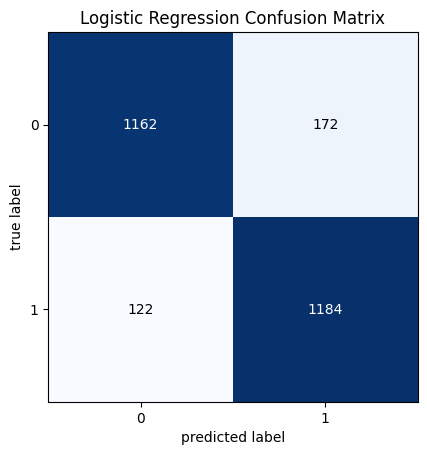


Random Forest Results:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1334
           1       0.95      0.98      0.97      1306

    accuracy                           0.97      2640
   macro avg       0.97      0.97      0.97      2640
weighted avg       0.97      0.97      0.97      2640

Cross-validation scores: [0.9749053  0.96685606 0.96354167 0.96399811 0.97299858]
Mean CV accuracy: 0.97


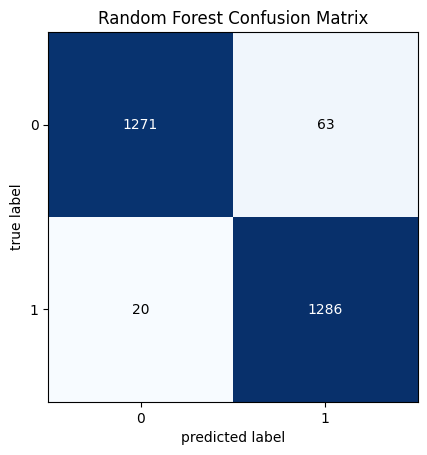


XGBoost Results:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1334
           1       0.95      0.99      0.97      1306

    accuracy                           0.97      2640
   macro avg       0.97      0.97      0.97      2640
weighted avg       0.97      0.97      0.97      2640

Cross-validation scores: [0.98058712 0.97679924 0.97301136 0.97110374 0.97584083]
Mean CV accuracy: 0.98


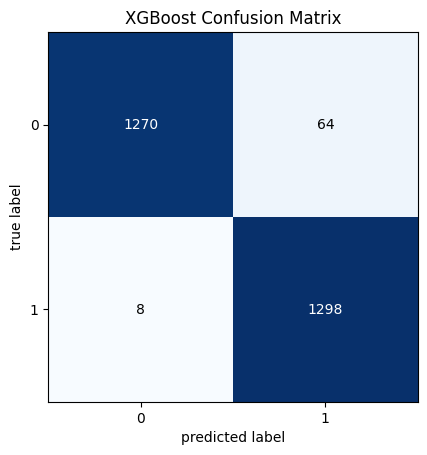


KNeighbourClassifier Results:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1334
           1       0.88      1.00      0.94      1306

    accuracy                           0.93      2640
   macro avg       0.94      0.93      0.93      2640
weighted avg       0.94      0.93      0.93      2640

Cross-validation scores: [0.94081439 0.93418561 0.92755682 0.92846992 0.93889152]
Mean CV accuracy: 0.93


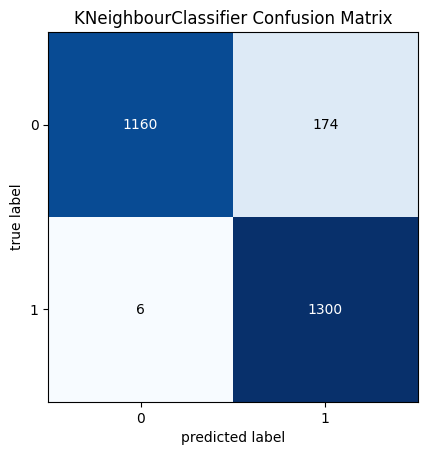


Deep Learning Results:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1334
           1       0.96      1.00      0.98      1306

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640

Cross-validation scores: [0.97964015 0.97537879 0.97916667 0.97820938 0.98199905]
Mean CV accuracy: 0.98


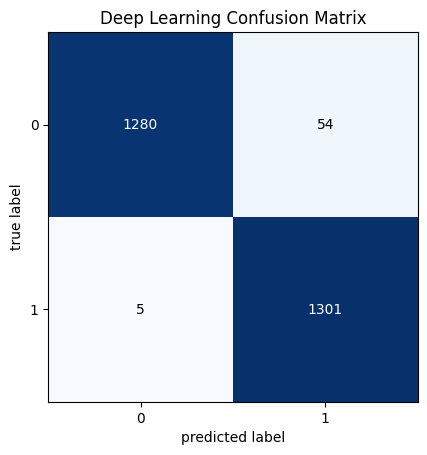

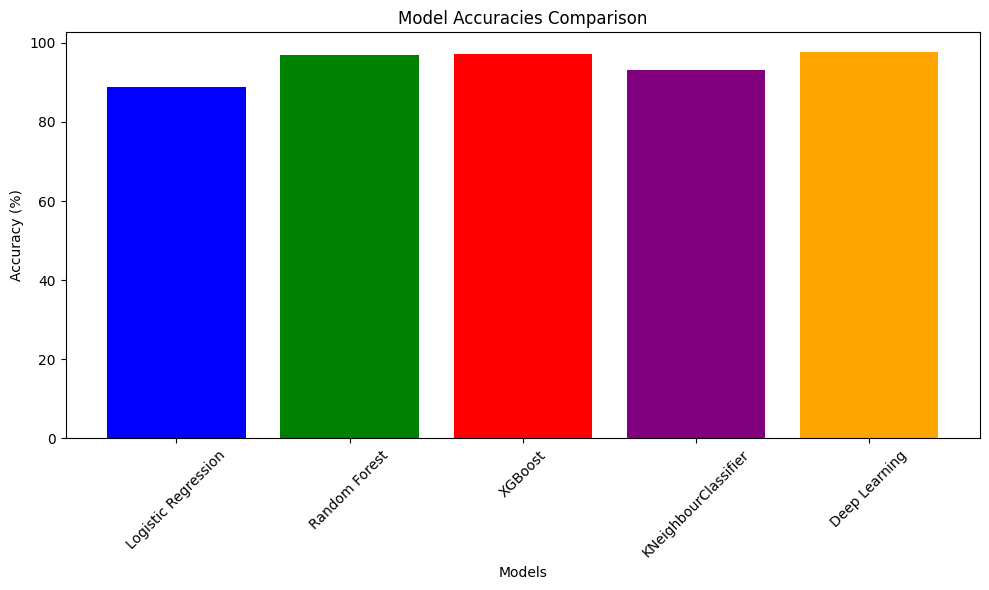

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List, Any
from pathlib import Path

from mlxtend.plotting import plot_confusion_matrix
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings('ignore')

@dataclass
class ModelConfig:
    model: BaseEstimator
    name: str
    color: str

class BankruptcyPredictor:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.models = [
            ModelConfig(
                LogisticRegression(max_iter=1000),
                "Logistic Regression",
                "blue"
            ),
            ModelConfig(
                RandomForestClassifier(n_estimators=20),
                "Random Forest",
                "green"
            ),
            ModelConfig(
                XGBClassifier(objective="binary:logistic", random_state=42),
                "XGBoost",
                "red"
            ),
            ModelConfig(
                KNeighborsClassifier(n_neighbors=7),
                "KNeighbourClassifier",
                "purple"
            ),
            ModelConfig(
                MLPClassifier(max_iter=500, random_state=0),
                "Deep Learning",
                "orange"
            )
        ]

    def load_and_preprocess_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Load and preprocess the dataset."""
        df = pd.read_csv(self.data_path)
        
        # Encode target variable
        le = LabelEncoder()
        df['Bankrupt?'] = le.fit_transform(df['Bankrupt?'])
        
        # Split features and target
        X = df.drop(['Bankrupt?'], axis=1)
        y = df['Bankrupt?']
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, y

    def apply_smote(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Apply SMOTE for handling class imbalance."""
        smote = SMOTE()
        return smote.fit_resample(X, y)

    def select_features(self, X_train: np.ndarray, y_train: np.ndarray, 
                       X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Perform feature selection using Logistic Regression."""
        selector = SelectFromModel(LogisticRegression(max_iter=1000))
        selector.fit(X_train, y_train)
        return selector.transform(X_train), selector.transform(X_test)

    def evaluate_model(self, model: BaseEstimator, X_train: np.ndarray, 
                      X_test: np.ndarray, y_train: np.ndarray, 
                      y_test: np.ndarray, name: str) -> Tuple[str, float]:
        """Train and evaluate a single model."""
        # Feature selection
        X_train_selected, X_test_selected = self.select_features(X_train, y_train, X_test)
        
        # Model training
        model.fit(X_train_selected, y_train)
        
        # Predictions and evaluation
        y_pred = model.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred) * 100
        
        # Print detailed results
        print(f"\n{name} Results:")
        print(classification_report(y_test, y_pred))
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5)
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV accuracy: {cv_scores.mean():.2f}")
        
        # Plot confusion matrix
        self._plot_confusion_matrix(y_test, y_pred, name)
        
        return name, accuracy

    def _plot_confusion_matrix(self, y_true: np.ndarray, y_pred: np.ndarray, 
                             title: str) -> None:
        """Plot confusion matrix for model predictions."""
        conf_mat = confusion_matrix(y_true, y_pred)
        fig, ax = plot_confusion_matrix(conf_mat=conf_mat)
        plt.title(f"{title} Confusion Matrix")
        plt.show()

    def plot_accuracies(self, results: List[Tuple[str, float]]) -> None:
        """Plot comparison of model accuracies."""
        names, accuracies = zip(*results)
        colors = [model.color for model in self.models]
        
        plt.figure(figsize=(10, 6))
        plt.bar(names, accuracies, color=colors)
        plt.xlabel('Models')
        plt.ylabel('Accuracy (%)')
        plt.title('Model Accuracies Comparison')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def run(self):
        """Execute the complete modeling pipeline."""
        # Load and preprocess data
        X, y = self.load_and_preprocess_data()
        print(f"Original class distribution:\n{pd.Series(y).value_counts()}")
        
        # Apply SMOTE
        X_balanced, y_balanced = self.apply_smote(X, y)
        print(f"\nBalanced class distribution:\n{pd.Series(y_balanced).value_counts()}")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.2, random_state=42
        )
        
        # Train and evaluate models
        results = []
        for model_config in self.models:
            result = self.evaluate_model(
                model_config.model, X_train, X_test, y_train, y_test, model_config.name
            )
            results.append(result)
        
        # Plot final results
        self.plot_accuracies(results)

def main():
    data_path = Path('dataset/data.csv')
    predictor = BankruptcyPredictor(data_path)
    predictor.run()

if __name__ == "__main__":
    main()